In [3]:
import os
import itertools
import pathlib
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import ConcatDataset

PROJECT_DIR = os.path.dirname(os.getcwd())
if PROJECT_DIR not in sys.path:
    sys.path.insert(0, PROJECT_DIR)

from chord_recognition.cache import HDF5Cache
from chord_recognition.dataset import prepare_datasource, ChromaDataset, undersample_dataset
from chord_recognition.ann_utils import build_ann_df, convert_chord_label

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 200)
#pd.set_option('display.width', 1000)

%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 5)
sns.set(style="whitegrid")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Helpers

def plot_dataset(values, labels, title='chords distribution'):
    targets, counts = np.unique(values, return_counts=True)
    df = pd.DataFrame(counts, columns=['count'])
    
    chord_map = {idx: label for idx, label in enumerate(labels)}
    labels = [chord_map.get(t, 'unk') for t in targets]
    df.index = labels
    g = sns.catplot(data=df, x=df.index, y='count', kind="bar", height=8)
    g.fig.suptitle(title, fontsize=14)

In [137]:
ds = prepare_datasource(('beatles',))
dataset = ChromaDataset(
    ds, window_size=8192, hop_length=4096,
    cache=HDF5Cache('chroma_cache.hdf5'))

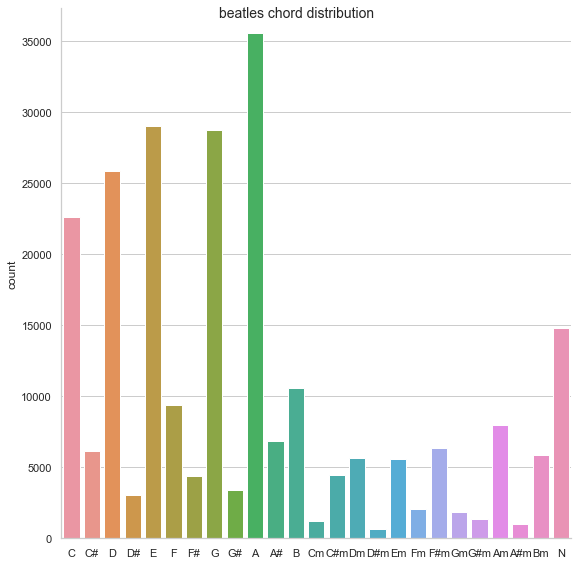

In [131]:
plot_dataset(
    values=[l for _, l in dataset],
    labels=dataset.chord_labels,
    title='beatles chord distribution')

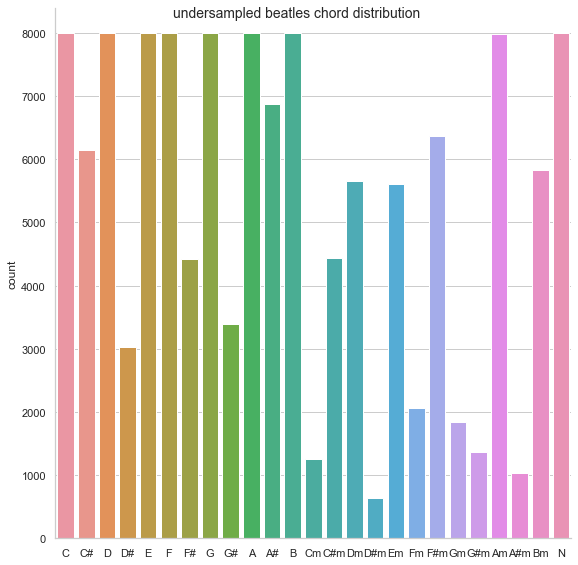

In [138]:
sampling_strategy = {
    0: 8000,
    2: 8000,
    4: 8000,
    5: 8000,
    7: 8000,
    9: 8000,
    11: 8000,
    24: 8000,
}
_, by = undersample_dataset(dataset, sampling_strategy, random_state=11)
plot_dataset(
    values=by,
    labels=dataset.chord_labels,
    title='undersampled beatles chord distribution')

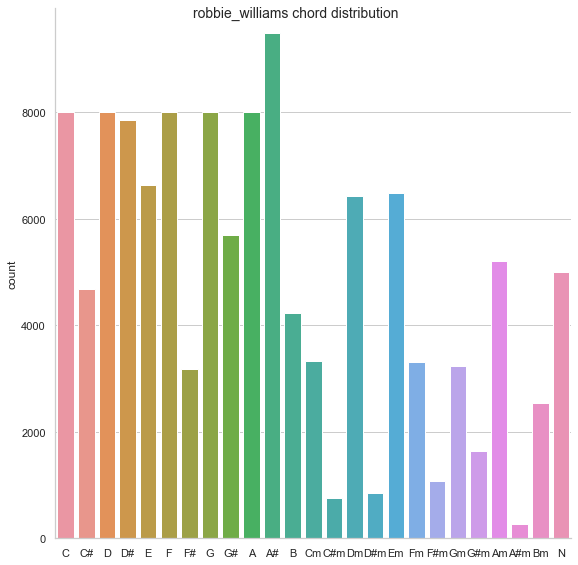

In [157]:
ds = prepare_datasource(('robbie_williams',))
dataset = ChromaDataset(
    ds, window_size=8192, hop_length=4096,
    cache=HDF5Cache('chroma_cache.hdf5'))

sampling_strategy = {
    0: 8000,
    2: 8000,
    5: 8000,
    7: 8000,
    9: 8000,
    24: 5000,
}
_, ry = undersample_dataset(dataset, sampling_strategy, random_state=11)
plot_dataset(
    values=ry,
    labels=dataset.chord_labels,
    title='robbie_williams chord distribution')

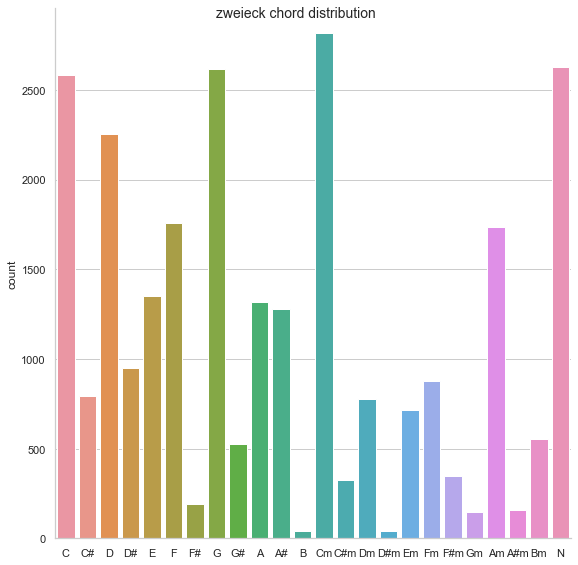

In [140]:
ds = prepare_datasource(('zweieck',))
dataset = ChromaDataset(
    ds, window_size=8192, hop_length=4096,
    cache=HDF5Cache('chroma_cache.hdf5'))
zy = [yi for _, yi in dataset]
plot_dataset(
    values=zy,
    labels=dataset.chord_labels,
    title='zweieck chord distribution')

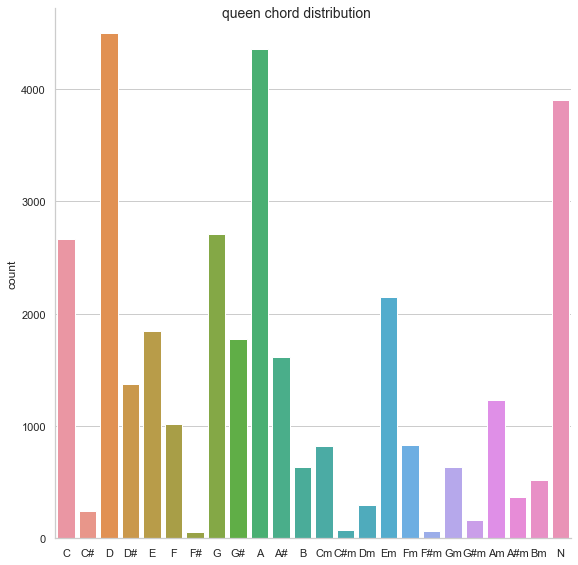

In [156]:
ds = prepare_datasource(('queen',))
dataset = ChromaDataset(
    ds, window_size=8192, hop_length=4096,
    cache=HDF5Cache('chroma_cache.hdf5'))


sampling_strategy = {
    2: 4500,
}
_, qy = undersample_dataset(dataset, sampling_strategy, random_state=11)
plot_dataset(
    values=qy,
    labels=dataset.chord_labels,
    title='queen chord distribution')

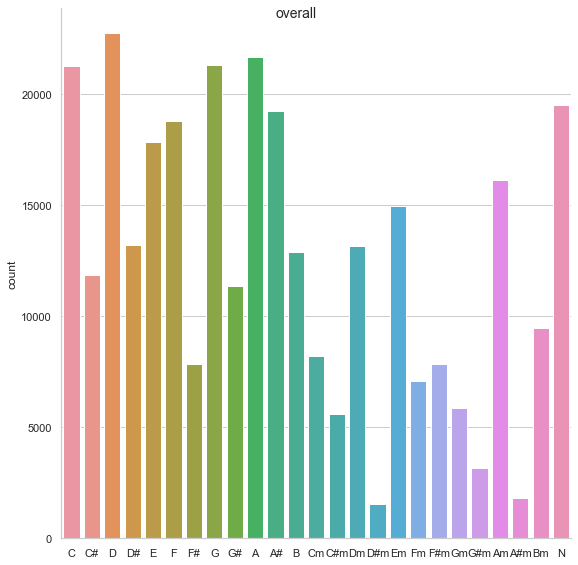

In [148]:
plot_dataset(
    values=by+ry+zy+qy,
    labels=dataset.chord_labels,
    title='overall')

In [6]:
# https://www.music-ir.org/mirex/wiki/2020:Audio_Chord_Estimation
maj_chords = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
min_chords = [c + 'm' for c in maj_chords]

seventh_labels = ['maj7', 'min7', '7']
seventh_chords = set([c + l for l in seventh_labels for c in list(maj_chords)])

inversions_labels = ['/3', 'min/b3', '/5', 'min/5']
inversions_chords = set([c + l for l in inversions_labels for c in list(maj_chords)])

seventh_inversions_labels = ['maj7/3', 'min7/b3', '7/3', 'maj7/5', 'min7/5', '7/5', 'maj7/7', 'min7/b7', '7/b7']

In [13]:
# Define some usefull helpers

def build_df(annotations):
    datasets = []
    for ann in annotations:
        chords_df = build_ann_df(ann)
        datasets.append(chords_df)
                
    chords_df = pd.concat(datasets)
    chords_df = convert_chord_label(chords_df)
    return chords_df

def audio_stats_df(annotations):
    index = [ann.split('/')[-1].replace('.lab', '') for ann in annotations]
    audio_df = pd.DataFrame(
        columns=list(maj_chords) + list(min_chords) + ['N'],
        index=index)
    for i, ann in enumerate(annotations):
        df = build_ann_df(ann)
        df = convert_chord_label(df)
        df = df[df.label.isin(maj_chords + min_chords + ['N'])]
        audio_df.iloc[i] = df['label'].value_counts()
    #audio_df = audio_df.replace(np.nan, '', regex=True)
    return audio_df

def preprocess_chords(df):
    chords_df = df.copy()
    chords_df['vocab'] = chords_df.label.apply(lambda x: mark_vocabulary(x))
    return chords_df

def mark_vocabulary(label):
    if label in maj_chords:
        return 'maj'
    elif label in min_chords:
        return 'min'
    elif label in seventh_chords:
        return 'seventh'
    elif label in inversions_chords:
        return 'inv'
    elif label == 'N':  # exclude `N` from other
        return 'N'
    else:
        return 'other'
    
def chord_class_distribution(df, title='Chord Class distribution'):
    print(df.groupby('vocab').size() / len(df))
    ax = sns.countplot(x="vocab", hue='vocab', data=df, dodge=False).set_title(title)
    
def chord_distribution(df, column='label', minmaj=False, stats=False, title='Chord distribution'):
    df = df.copy()
    orig_count = df['label'].value_counts().sum()
    if minmaj:
        df = df[df.label.isin(list(maj_chords) + list(min_chords) + ['N'])]
    
    sns.countplot(column, data=df.sort_values([column]))
    if stats:
        df = pd.DataFrame(df['label'].value_counts())
        #df['ratio'] = df.label.apply(lambda x: x / df.label.sum())
        df['ratio'] = df.label.apply(lambda x: x / orig_count)
        print(df)
        print('Overall ratio: {0:.3f}'.format(df['ratio'].sum()))

In [173]:
ds = prepare_datasource(('zweieck',))
ds = [lab for lab,_ in ds]
audio_df = audio_stats_df(ds)
audio_df

,C,C#,D,D#,E,F,F#,G,G#,A,A#,B,Cm,C#m,Dm,D#m,Em,Fm,F#m,Gm,G#m,Am,A#m,Bm,N
01_-_Spiel_Mir_Eine_Alte_Melodie,25,,,,,1,,12,,,,,,,,,,,,,,,,,4.0
02_-_Rawhide,7,,,,18,4,,12,,,,,,,14,,1,,,,,47,,2,5.0
03_-_She,,2,,2,,1,1,,2,,11,,,,,1,,,,,,,,,4.0
04_-_Erbauliche_Gedanken_Eines_Tobackrauchers,2,15,,15,,30,,,,1,8,,,,4,,,,,2,,,,,3.0
05_-_Andersrum,13,,,,,12,,8,,2,,,,,11,,4,,,,,,,,3.0
06_-_Tigerfest,6,,2,,9,3,,6,,6,,,,8,3,,,,,,,2,,6,4.0
07_-_Akne,,,,,2,23,3,14,1,,,,,,3,1,9,1,,,,11,4,,7.0
08_-_Blass,2,4,3,,,,,3,,2,6,,1,,1,,,,4,3,,8,,3,4.0
09_-_Mr_Morgan,2,,55,,,4,2,52,,7,,,,,,,,,,,,,,,3.0
10_-_Liebesleid,14,9,,7,,,,17,7,,5,,13,,8,,,5,,,,,,,5.0


In [178]:
ds = prepare_datasource(('queen',))
ds = [lab for lab,_ in ds]
audio_df = audio_stats_df(ds)
audio_df

,C,C#,D,D#,E,F,F#,G,G#,A,A#,B,Cm,C#m,Dm,D#m,Em,Fm,F#m,Gm,G#m,Am,A#m,Bm,N
01 Bohemian Rhapsody,,3,3,28,1,6,2,,9,13,30,3,14,,,,,6,,9,2,,1,,3.0
02 Another One Bites The Dust,12,,,,,,,12,,,,3,,,,,27,,,,,26,,,5.0
04 Fat Bottomed Girls,4,,34,,,1,,11,,16,,,,,,,,,,,,,,,3.0
05 Bicycle Race,3,,7,3,1,5,1,2,19,3,3,5,,,2,,,,,,,1,21,,4.0
06 You're My Best Friend,26,,6,,2,8,,14,,,,,,,,,,2,,,,10,,,2.0
07 Don't Stop Me Now,9,,,,,17,,,1,1,8,,,,15,,,,,17,,5,,,3.0
08 Save Me,27,,29,,,,,31,,3,,,,,,,1,,,,,8,,,2.0
09 Crazy Little Thing Called Love,22,,26,,4,2,,18,,4,16,,,,,,,,,,,,,,8.0
10 Somebody To Love,,16,,9,,,1,,35,,1,,,,,,,18,1,,,,,,6.0
12 Good Old-Fashioned Lover Boy,,,,25,,,,,12,,9,3,22,,,,,11,,19,11,,,,2.0


In [190]:
ds = [lab for lab,_ in prepare_datasource(('robbie_williams',))]
audio_df = audio_stats_df(ds)
audio_df

,C,C#,D,D#,E,F,F#,G,G#,A,A#,B,Cm,C#m,Dm,D#m,Em,Fm,F#m,Gm,G#m,Am,A#m,Bm,N
01-Lazy Days,12,3,,16,,34,,,6,,6,,,,,,,,,4,,2,,,3
02-Life Thru A Lens,5,1,14,,2,6,,13,,11,,,,9,,,,,4,,,,,2,2
03-Ego A Go Go,,12,,42,,,3,,35,,3,12,,,,,,,,,,,6,,2
04-Angels,,,7,,16,,,,,19,,10,,7,,,,,8,,,,,4,2
05-South Of The Border,51,,2,,,17,,28,,,1,,,,,,8,,,6,,4,,,2
06-Old Before I Die,9,,5,,2,9,,13,,22,1,1,,,6,,,2,13,,,8,,4,1
07-One Of God's Better People,7,,3,,,10,,14,,1,,,5,,,,13,,,,,24,,4,2
08-Let Me Entertain You,,,,,,34,,,17,,18,,,,,,,,,,,,,,1
09-Killing Me,1,,,,3,2,,8,,18,,,,,2,,4,,,,,7,,,2
10-Clean,4,10,,16,,36,,10,,,19,,,,,,,,,,,,,,2


[Chord and Harmony annotations of the first five albums by Robbie Williams](https://www.researchgate.net/publication/260399240_Chord_and_Harmony_annotations_of_the_first_five_albums_by_Robbie_Williams) by M. Zanoni

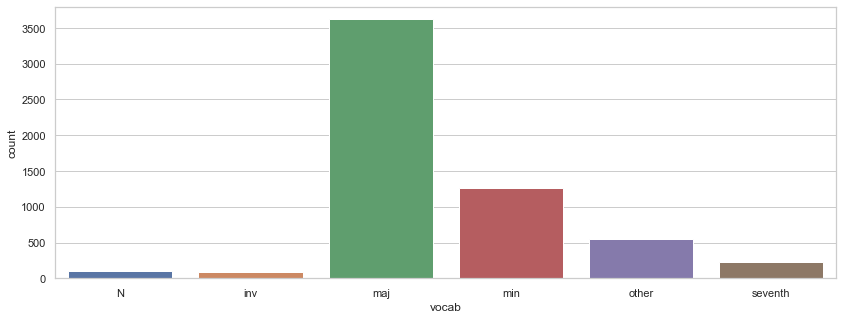

In [320]:
excluded_files = (
    '11-Man Machine',
    '01-Ghosts',
    '11-A Place To Crash',
    '08-Heaven From Here',
    '09-Random Acts Of Kindness',
    '05-South Of The Border',
)
robbie_ds = [ann for ann, _ in prepare_datasource(('robbie_williams',), excluded_files=excluded_files)]
robbie_df = build_df(robbie_ds)
robbie_df = preprocess_chords(robbie_df)
chord_distribution(robbie_df, column='vocab', title='Robbie Williams')

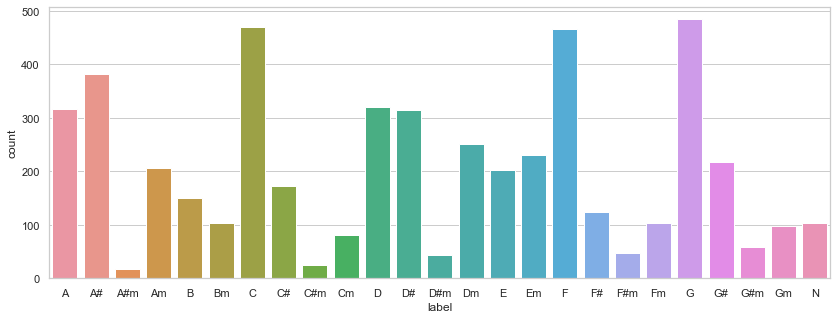

In [292]:
chord_distribution(robbie_df, column='label', minmaj=True, title='Robbie Williams')

### Isophonics datasets

includes `The Beatles`, `Queen` and `Zweieck`

[source](http://www.isophonics.net/datasets)

In [321]:
#isophonics_ds = prepare_datasource(('queen', 'beatles', 'zweieck'))
excluded_files=(
    # zweieck
    '09_-_Mr_Morgan',
    '01_-_Spiel_Mir_Eine_Alte_Melodie',
    '11_-_Ich_Kann_Heute_Nicht',
    # queen
    '14 Hammer To Fall',
    '08 Save Me',
)
isophonics_ds = [ann for ann, _ in prepare_datasource(('zweieck', 'queen'), excluded_files=excluded_files)]
isophonics_df = build_df(isophonics_ds)
isophonics_df = preprocess_chords(isophonics_df)
#chord_distribution(isophonics_df, column='vocab', title='Isophonics')

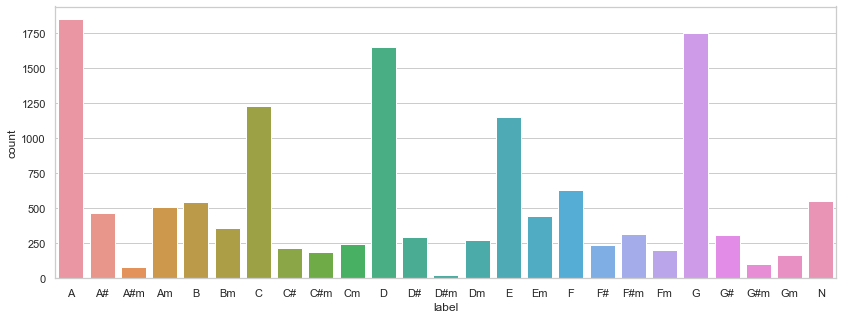

In [311]:
# Isophonics chords distribution
chord_distribution(isophonics_df, minmaj=True)

In [322]:
allowed_files = (
    '06-Mr_Moonlight',
    '06-Yellow_Submarine',
    '03-I_m_Only_Sleeping',
    '09-Penny_Lane',
    '12-Wait',
    '11-Do_You_Want_To_Know_A_Secret',
    '12-A_Taste_Of_Honey',
    '04-I_m_Happy_Just_To_Dance_With_You',
    '03-If_I_Fell',
    '10-I_m_Looking_Through_You',
    '09-When_I_m_Sixty-Four',
    '06-Till_There_Was_You',
    '05-Octopus_s_Garden',
    '03-All_My_Loving',
    '05-And_I_Love_Her',
    '02-All_I_ve_Got_To_Do',
    '10-For_No_One',
    '08-Because',
    '06-She_s_Leaving_Home',
    '04-Chains',
    '10-Things_We_Said_Today',
    '09-One_After_909',
    '09-Girl',
    '14-Run_For_Your_Life',
    '04-Oh_Darling',
    '04-Don_t_Bother_Me',
    '06-I_Want_You_She_s_So_Heavy_',
    '06-Tell_Me_Why',
)
beatles_ds = [ann for ann, _ in prepare_datasource(('beatles',), allowed_files=allowed_files)]
beatles_df = build_df(beatles_ds)
beatles_df = preprocess_chords(beatles_df)

In [323]:
isophonics_df = pd.concat([isophonics_df, beatles_df])

     label     ratio
G      771  0.063488
C      677  0.055748
A      669  0.055089
F      647  0.053277
D      606  0.049901
A#     568  0.046772
D#     476  0.039196
E      462  0.038043
Em     426  0.035079
G#     410  0.033762
Am     401  0.033020
B      379  0.031209
Dm     354  0.029150
C#     338  0.027833
Cm     294  0.024209
N      294  0.024209
F#     278  0.022892
Bm     249  0.020504
Fm     242  0.019928
F#m    205  0.016881
Gm     198  0.016304
C#m    151  0.012434
G#m    144  0.011858
A#m     81  0.006670
D#m     70  0.005764


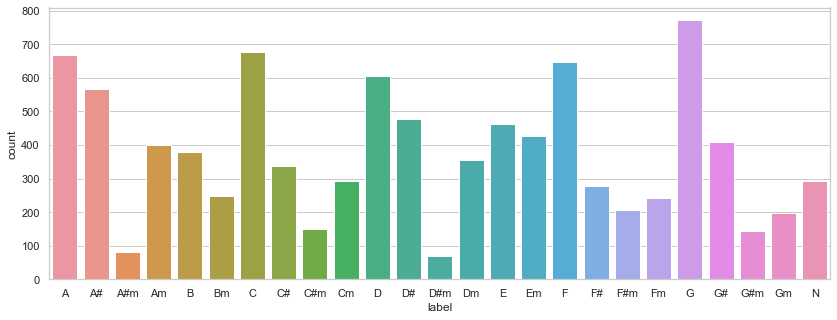

In [324]:
# Robbie Williams and Isophonics chords distribution

total_df = pd.concat([isophonics_df, robbie_df])

# Print imbalance ratio of a multi-class dataset
# It may be usefull for initialization to speed up convergence of a network.
chord_distribution(total_df, minmaj=True, stats=True)

In [301]:
total_ds = beatles_ds + isophonics_ds + robbie_ds
print('total ds len:', len(total_ds))
audio_df = audio_stats_df(total_ds)

total ds len: 117


In [308]:
# ds = prepare_datasource(('beatles',))
# ds = [lab for lab,_ in ds]
# audio_df = audio_stats_df(ds)
# audio_df.sort_values('F#', ascending=False)

In [300]:
audio_df.sort_values('G', ascending=False)

,C,C#,D,D#,E,F,F#,G,G#,A,A#,B,Cm,C#m,Dm,D#m,Em,Fm,F#m,Gm,G#m,Am,A#m,Bm,N
04 I Want It All,NaN,NaN,3,NaN,1,NaN,NaN,42,NaN,47,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33,3
12-These Dreams,8,NaN,10,NaN,1,NaN,NaN,37,NaN,12,1,NaN,NaN,NaN,19,NaN,12,NaN,8,1,NaN,1,NaN,NaN,2
07-Revolution,26,NaN,14,NaN,16,20,2,33,NaN,2,NaN,NaN,NaN,NaN,42,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,7,2
17_-_Duell,1,3,NaN,NaN,NaN,NaN,NaN,30,4,NaN,NaN,NaN,57,NaN,1,NaN,NaN,14,NaN,NaN,NaN,NaN,NaN,NaN,7
07-Your Gay Friend,25,NaN,22,NaN,NaN,NaN,NaN,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22,NaN,2,NaN,NaN,7,NaN,19,2
11-Song 3,25,NaN,NaN,10,NaN,18,NaN,27,NaN,6,29,NaN,NaN,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
06-Please Don't Die,43,NaN,NaN,NaN,NaN,22,NaN,24,NaN,NaN,NaN,NaN,NaN,NaN,22,NaN,16,NaN,NaN,NaN,NaN,36,NaN,NaN,1
01-How Peculiar,13,NaN,14,7,NaN,NaN,NaN,24,NaN,4,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,NaN,NaN,NaN,NaN,2
08-Handsome Man,7,2,26,7,NaN,NaN,NaN,21,6,26,10,1,NaN,NaN,NaN,NaN,21,6,NaN,NaN,NaN,NaN,NaN,4,2
05-Sexed Up,27,NaN,NaN,NaN,5,24,NaN,20,NaN,NaN,1,NaN,NaN,NaN,2,NaN,16,4,NaN,6,NaN,8,NaN,NaN,2


   label     ratio
G     11  0.169231
D      6  0.092308
A      5  0.076923
F      3  0.046154
C      3  0.046154
N      2  0.030769
Overall ratio: 0.462


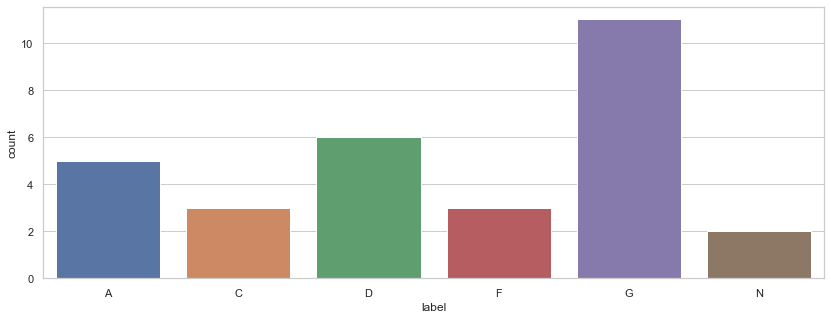

In [22]:
# Take a look at a specific audio targets
df = build_ann_df("data/beatles/chordlabs/Rubber_Soul/06-The_Word.lab")
df = convert_chord_label(df)
df = preprocess_chords(df)
chord_distribution(df, stats=True, minmaj=True, title='03_-_She')